### **Importações Iniciais**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de Machine Learning
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import fbeta_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    recall_score,
    precision_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
    accuracy_score
)
from imblearn.over_sampling import SMOTE

### **Configuração de estilo dos gráfico**

In [ ]:
# Configuração de estilo dos gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### **Carregamento e Pré-processamento dos Dados**

In [ ]:
# 1. Carregar os arquivos gerados pelo tratamento
train_df = pd.read_csv('fetal_health_train.csv')
test_df = pd.read_csv('fetal_health_test.csv')

In [ ]:
def get_binary_target(val):
    """
    Converte a classificação multiclasse em binária.

    Args:
        val (float): Valor original da classe (1.0, 2.0, 3.0).

    Returns:
        int: 0 para Normal (1.0), 1 para Risco (2.0 ou 3.0).
    """
    return 0 if val == 1.0 else 1


# 2. Aplicar a transformação nos conjuntos de treino e teste
# Usamos .copy() para evitar avisos de SettingWithCopy
X_train = train_df.drop('fetal_health', axis=1).copy()
y_train = train_df['fetal_health'].apply(get_binary_target)

X_test = test_df.drop('fetal_health', axis=1).copy()
y_test = test_df['fetal_health'].apply(get_binary_target)

print("Distribuição das classes no Treino:")
print(y_train.value_counts())

Distribuição das classes no Treino:
fetal_health
0    1152
1     327
Name: count, dtype: int64


### **Validação Cruzada (Cross-Validation)**

In [ ]:
# 3. Configurar Cross-Validation (5 Folds Estratificados)
# StratifiedKFold garante a mesma proporção de classes em cada dobra
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Listas para armazenar métricas de cada fold
metrics = []
tprs = []  # Taxas de Verdadeiro Positivo (para curva ROC média)
mean_fpr = np.linspace(0, 1, 100)  # Eixo X comum para interpolação

plt.figure(figsize=(10, 8))
print("Iniciando Cross-Validation...")

Iniciando Cross-Validation...


<Figure size 1000x800 with 0 Axes>

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:17:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:17:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:17:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:17:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:17:52] WARNING: /w

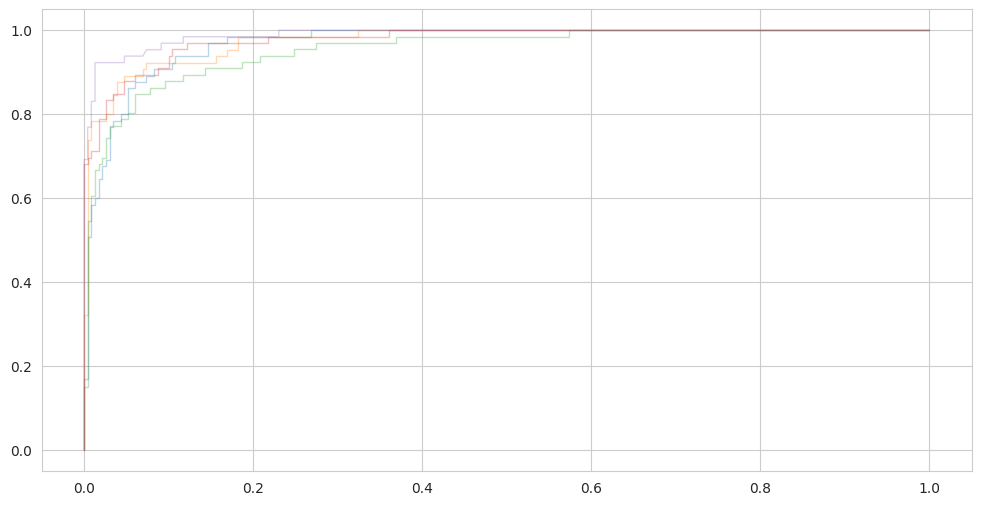

In [ ]:
# 4. Loop de Treino e Validação
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    # Separar dados baseados nos índices do fold atual
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Hiperparâmetros otimizados (obtidos via Ray Tune)
    model = XGBClassifier(
        n_estimators=312,
      learning_rate=0.08473899682152258,
      max_depth=3,
      subsample=0.7965561088502103,
      colsample_bytree=0.8313043969649337,
      gamma=1.8300822005865647,
      min_child_weight=2,
      scale_pos_weight=4.749952001562421,
      use_label_encoder=False,
      eval_metric='logloss',
      random_state=42
    )

    # Treinar o modelo na dobra atual
    model.fit(X_train_fold, y_train_fold)

    # Gerar predições
    probas = model.predict_proba(X_val_fold)[:, 1]
    preds = model.predict(X_val_fold)

    # Calcular e armazenar métricas
    metrics.append({
        'Fold': fold + 1,
        'AUC': roc_auc_score(y_val_fold, probas),
        'Recall': recall_score(y_val_fold, preds),
        'Precision': precision_score(y_val_fold, preds),
        'F1': f1_score(y_val_fold, preds)
    })

    # Calcular Curva ROC para este fold
    fpr, tpr, _ = roc_curve(y_val_fold, probas)

    # Interpolar para poder calcular a média depois
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

    # Plotar a linha do fold atual (transparente)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {fold + 1}')


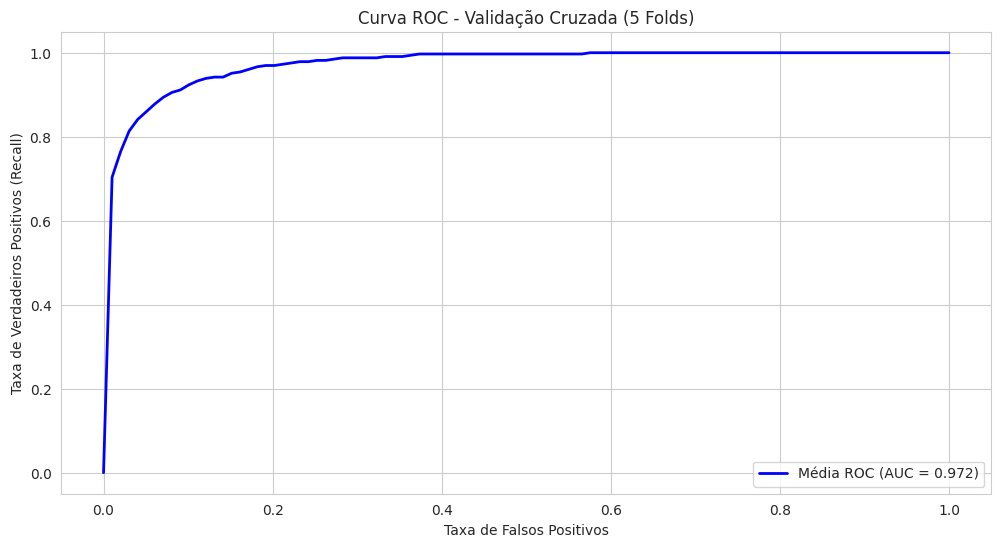


--- Resultados Detalhados por Fold ---
   Fold       AUC    Recall  Precision        F1
0     1  0.971229  0.907692   0.746835  0.819444
1     2  0.976091  0.923077   0.722892  0.810811
2     3  0.955270  0.878788   0.725000  0.794521
3     4  0.977866  0.893939   0.797297  0.842857
4     5  0.989331  0.923077   0.845070  0.882353

--- Média das Métricas ---
Fold         3.000000
AUC          0.973957
Recall       0.905315
Precision    0.767419
F1           0.829997
dtype: float64


In [ ]:
# 5. Plotar a Curva ROC Média
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', label=f'Média ROC (AUC = {mean_auc:.3f})', lw=2)
plt.title('Curva ROC - Validação Cruzada (5 Folds)')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)')
plt.legend(loc="lower right")
plt.show()

# 6. Exibir Tabela de Resultados
metrics_df = pd.DataFrame(metrics)
print("\n--- Resultados Detalhados por Fold ---")
print(metrics_df)
print("\n--- Média das Métricas ---")
print(metrics_df.mean())

### **Avaliação Final e Ajuste de Limiar (Threshold)**

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:17:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Limiar Ajustado para Recall > 0.96: 0.0947
AUC-ROC Score Final: 0.9878


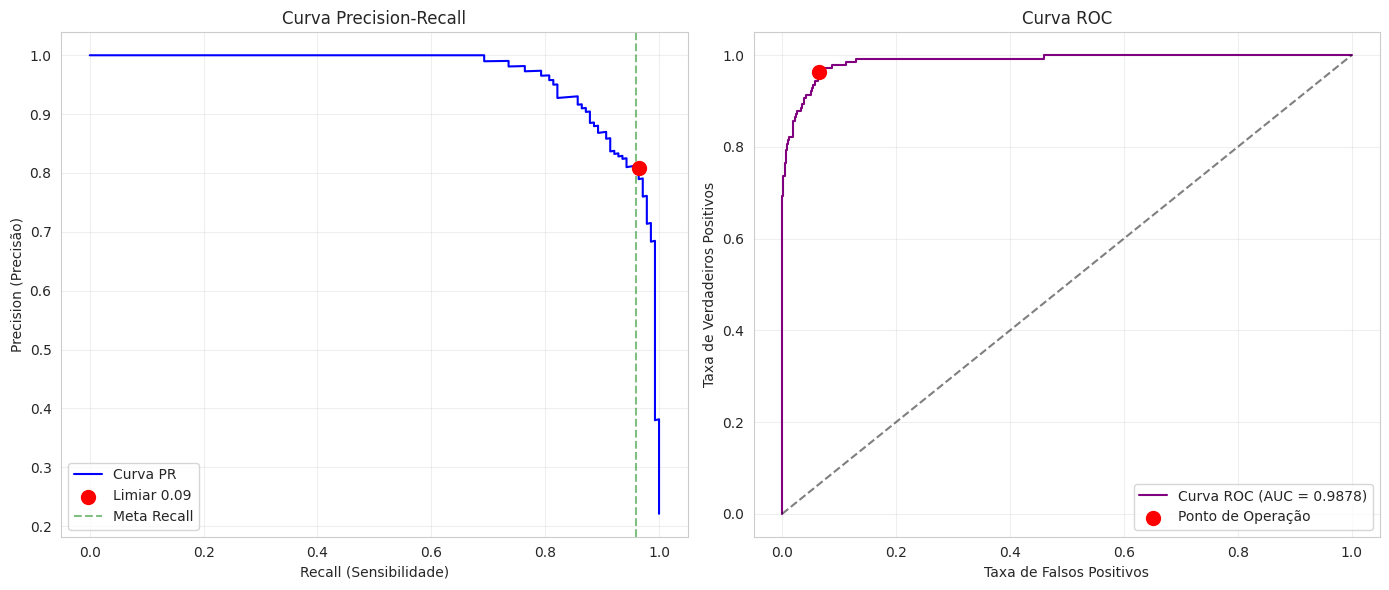


--- RELATÓRIO FINAL (COM AUC E LIMIAR AJUSTADO) ---
              precision    recall  f1-score   support

      Normal       0.99      0.94      0.96       494
       Risco       0.81      0.96      0.88       140

    accuracy                           0.94       634
   macro avg       0.90      0.95      0.92       634
weighted avg       0.95      0.94      0.94       634

F2-Score: 0.9285


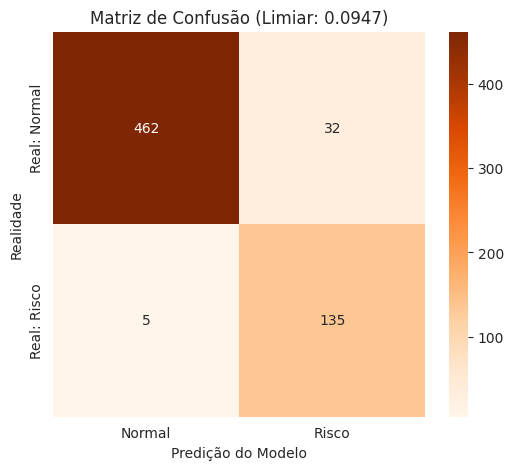

In [ ]:
# --- 1. Obter Probabilidades no Conjunto de Teste ---
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)[:, 1]

# --- 2. Calcular Curvas de Precisão e Recall ---
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# --- 3. Encontrar o Limiar Ótimo (Threshold Tuning) ---
TARGET_RECALL = 0.96  # Meta de segurança definida pelo negócio

# Encontrar índices onde o recall é maior ou igual à meta
valid_indices = np.where(recall[:-1] >= TARGET_RECALL)[0]

if len(valid_indices) > 0:
    # Selecionar o índice que maximiza o limiar (para preservar a precisão)
    best_idx = valid_indices[-1]
    optimal_threshold = pr_thresholds[best_idx]
else:
    optimal_threshold = 0.5  # Fallback padrão

# Encontrar o ponto correspondente na curva ROC para plotagem
roc_idx = (np.abs(roc_thresholds - optimal_threshold)).argmin()
opt_fpr = fpr[roc_idx]
opt_tpr = tpr[roc_idx]

print(f"Limiar Ajustado para Recall > {TARGET_RECALL}: {optimal_threshold:.4f}")
print(f"AUC-ROC Score Final: {roc_auc:.4f}")

# --- 4. Plotagem das Curvas ---
plt.figure(figsize=(14, 6))

# Subplot 1: Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label='Curva PR', color='blue')
plt.scatter(
    recall[best_idx],
    precision[best_idx],
    color='red',
    s=100,
    label=f'Limiar {optimal_threshold:.2f}',
    zorder=5
)
plt.axvline(TARGET_RECALL, color='green', linestyle='--', alpha=0.5, label='Meta Recall')
plt.title('Curva Precision-Recall')
plt.xlabel('Recall (Sensibilidade)')
plt.ylabel('Precision (Precisão)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.4f})', color='purple')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # Linha de base aleatória
plt.scatter(
    opt_fpr,
    opt_tpr,
    color='red',
    s=100,
    label='Ponto de Operação',
    zorder=5
)
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 5. Relatório Final com Novo Limiar ---
# Converter probabilidades em classes usando o novo limiar
y_pred_new = (y_proba >= optimal_threshold).astype(int)
f2 = fbeta_score(y_test, y_pred_new, beta=2)

print("\n--- RELATÓRIO FINAL (COM AUC E LIMIAR AJUSTADO) ---")
print(classification_report(y_test, y_pred_new, target_names=['Normal', 'Risco']))
print(f"F2-Score: {f2:.4f}")

# Matriz de Confusão Visual
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_new)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=['Normal', 'Risco'],
    yticklabels=['Real: Normal', 'Real: Risco']
)
plt.title(f'Matriz de Confusão (Limiar: {optimal_threshold:.4f})')
plt.xlabel('Predição do Modelo')
plt.ylabel('Realidade')
plt.show()

Analisando quais features foram mais importantes para o modelo

In [ ]:
# Feature importance
feature_names = X_train_fold.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

In [ ]:
print(f"\n📊 Feature Importance (Random Forest):")
for i in range(min(5, len(indices))):
    idx = indices[i]
    print(f"  {feature_names[idx]}: {importances[idx]:.3f}")


📊 Feature Importance (Random Forest):
  accelerations: 0.213
  abnormal_short_term_variability: 0.206
  prolongued_decelerations: 0.197
  baseline value: 0.074
  uterine_contractions: 0.071


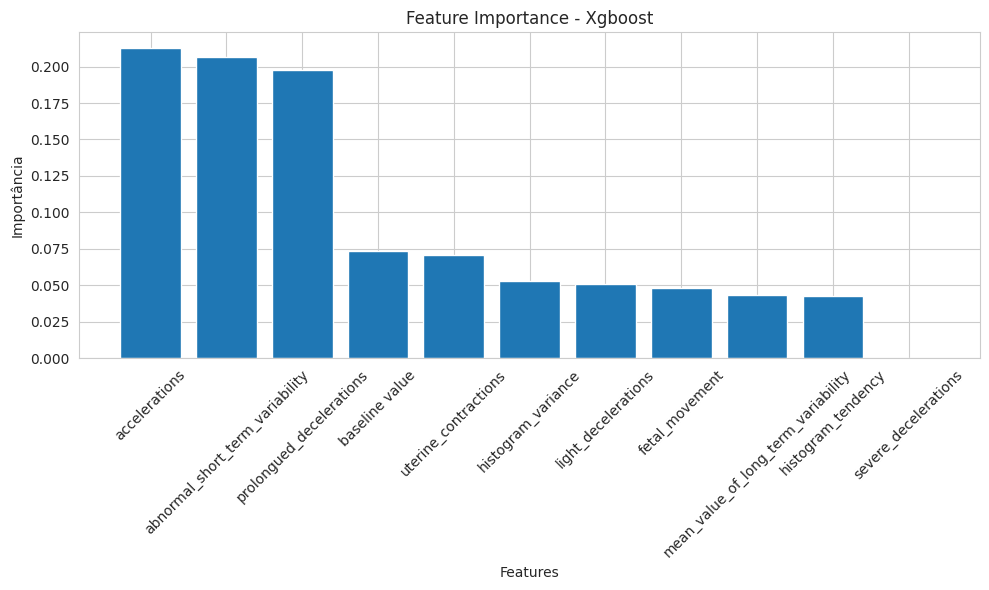

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xlabel('Features')
plt.ylabel('Importância')
plt.title('Feature Importance - Xgboost')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# 1. Carregar os arquivos
train_df = pd.read_csv('fetal_health_train_multi.csv')
test_df = pd.read_csv('fetal_health_test_multi.csv')

def get_multiclass_target(val):
    """
    Mapeia as classes originais para formato XGBoost (0, 1, 2).
    1.0 (Normal) -> 0
    2.0 (Suspeito) -> 1
    3.0 (Patológico) -> 2
    """
    return int(val) - 1  # Transformação simples: 1->0, 2->1, 3->2

# 2. Aplicar transformação
X_train = train_df.drop('fetal_health', axis=1).copy()
y_train = train_df['fetal_health'].apply(get_multiclass_target)

X_test = test_df.drop('fetal_health', axis=1).copy()
y_test = test_df['fetal_health'].apply(get_multiclass_target)

# Nomes das classes para os gráficos
class_names = ['Normal', 'Suspeito', 'Patológico']

print("Distribuição das Classes (Treino):")
print(y_train.value_counts().sort_index())

Distribuição das Classes (Treino):
fetal_health
0    1152
1     204
2     123
Name: count, dtype: int64


In [ ]:
# 3. Configurar Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics = []

print("Iniciando Cross-Validation Multiclasse...")

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # --- SOLUÇÃO DE DESBALANCEAMENTO MULTICLASSE ---
    # Calculamos um peso para cada linha de treino.
    # Classes raras ganham pesos maiores automaticamente.
    classes_weights = compute_sample_weight(
        class_weight='balanced',
        y=y_train_fold
    )

    # Configuração Multiclasse do XGBoost
    model = XGBClassifier(
       n_estimators= 165,
       max_depth= 4,
       learning_rate= 0.1510262681130135,
       subsample= 0.7037455790115761,
       colsample_bytree= 0.9329186650379793,
       gamma= 1.245681465998794,
       min_child_weight= 1,              # Número de classes
        eval_metric='mlogloss',     # Métrica de erro multiclasse
        use_label_encoder=False,
        random_state=42
    )

    # Treinar com pesos (sample_weight substitui scale_pos_weight)
    model.fit(X_train_fold, y_train_fold, sample_weight=classes_weights)

    # Predições
    probas = model.predict_proba(X_val_fold) # Retorna matriz (N, 3)
    preds = model.predict(X_val_fold)

    # Métricas
    # AUC 'ovr' (One-vs-Rest) calcula a média ponderada das AUCs de cada classe contra o resto
    roc_auc = roc_auc_score(y_val_fold, probas, multi_class='ovr', average='weighted')

    metrics.append({
        'Fold': fold + 1,
        'AUC': roc_auc,
        'F1-Macro': f1_score(y_val_fold, preds, average='macro'), # Média simples entre as 3 classes
        'Accuracy': accuracy_score(y_val_fold, preds)
    })

# Exibir Resultados
metrics_df = pd.DataFrame(metrics)
print("\n--- Resultados por Fold ---")
print(metrics_df)
print("\n--- Média ---")
print(metrics_df.mean())

Iniciando Cross-Validation Multiclasse...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:36:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:36:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:36:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:36:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:36:56] WARNING: /w


--- Resultados por Fold ---
   Fold       AUC  F1-Macro  Accuracy
0     1  0.959804  0.852177  0.895270
1     2  0.972953  0.815034  0.891892
2     3  0.982618  0.816154  0.898649
3     4  0.971584  0.816072  0.878378
4     5  0.983782  0.858833  0.915254

--- Média ---
Fold        3.000000
AUC         0.974148
F1-Macro    0.831654
Accuracy    0.895889
dtype: float64


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:37:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- RELATÓRIO FINAL MULTICLASSE ---
              precision    recall  f1-score   support

      Normal       0.97      0.91      0.94       494
    Suspeito       0.62      0.78      0.69        88
  Patológico       0.76      0.87      0.81        52

    accuracy                           0.89       634
   macro avg       0.79      0.85      0.82       634
weighted avg       0.91      0.89      0.90       634

F2-Score (Média Ponderada): 0.8926
F2-Score (Média Macro): 0.8373
AUC-ROC (One-vs-Rest Ponderado): 0.9752


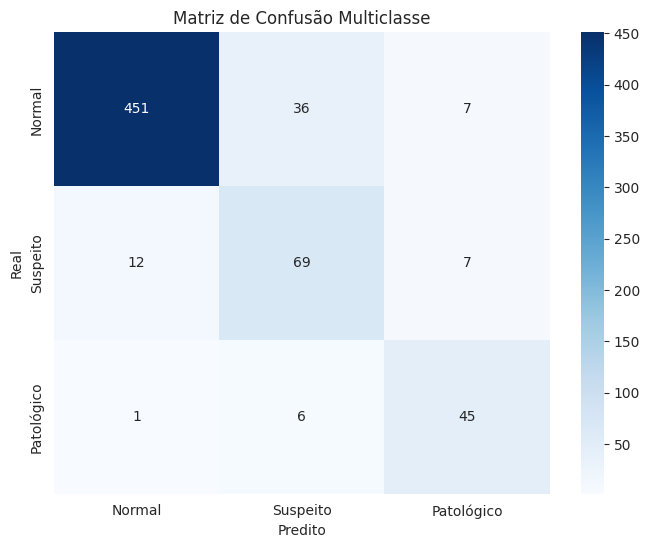

In [ ]:
# --- 1. Treinamento Final (Todos os dados) ---
# Calcular pesos para todo o conjunto de treino
final_weights = compute_sample_weight('balanced', y_train)

final_model = XGBClassifier(
       n_estimators= 165,
       max_depth= 4,
       learning_rate= 0.1510262681130135,
       subsample= 0.7037455790115761,
       colsample_bytree= 0.9329186650379793,
       gamma= 1.245681465998794,
       min_child_weight= 1,              # Número de classes
        eval_metric='mlogloss',     # Métrica de erro multiclasse
        use_label_encoder=False,
        random_state=42
)

final_model.fit(X_train, y_train, sample_weight=final_weights)

# --- 2. Predições no Teste ---
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)

# --- 3. Relatório Completo ---
print("\n--- RELATÓRIO FINAL MULTICLASSE ---")
print(classification_report(y_test, y_pred, target_names=class_names))
f2_weighted = fbeta_score(y_test, y_pred, beta=2, average='weighted')

# average='macro': Trata todas as classes com mesma importância (Bom para ver se está errando a classe rara)
f2_macro = fbeta_score(y_test, y_pred, beta=2, average='macro')

print(f"F2-Score (Média Ponderada): {f2_weighted:.4f}")
print(f"F2-Score (Média Macro): {f2_macro:.4f}")
roc_auc_final = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
print(f"AUC-ROC (One-vs-Rest Ponderado): {roc_auc_final:.4f}")

# --- 4. Matriz de Confusão ---
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matriz de Confusão Multiclasse')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

Analisando quais features foram mais importantes para o modelo

In [ ]:
# Feature importance
feature_names = X_train_fold.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

In [ ]:
print(f"\n📊 Feature Importance (Random Forest):")
for i in range(min(5, len(indices))):
    idx = indices[i]
    print(f"  {feature_names[idx]}: {importances[idx]:.3f}")


📊 Feature Importance (Random Forest):
  prolongued_decelerations: 0.239
  accelerations: 0.137
  abnormal_short_term_variability: 0.127
  baseline value: 0.096
  histogram_variance: 0.078


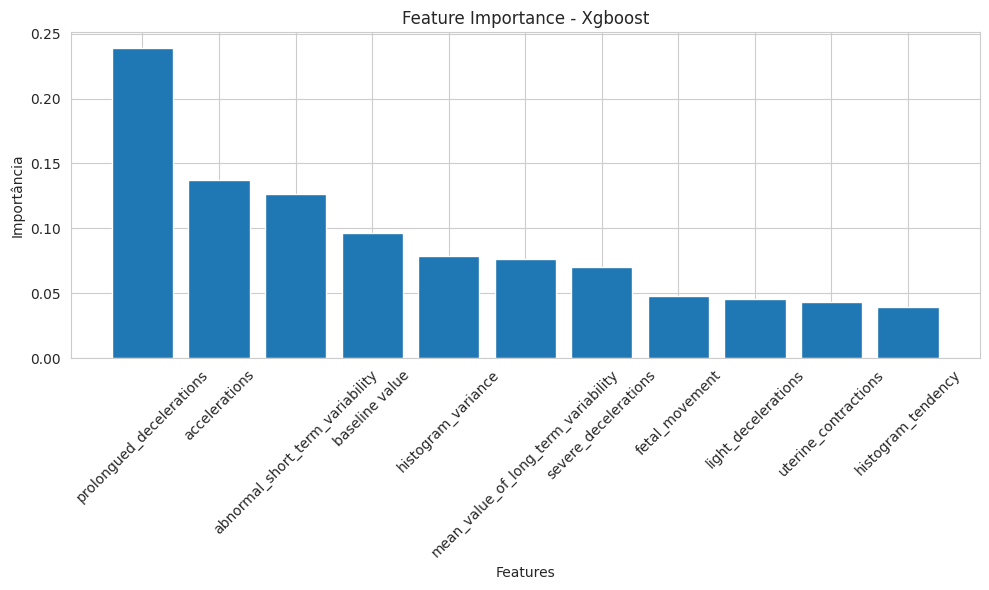

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xlabel('Features')
plt.ylabel('Importância')
plt.title('Feature Importance - Xgboost')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()